<h3> Import Header </h3>

In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from rembg import remove

import torch
import timm
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader 

<h3> Set Device </h3>

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

<h3> Set Hyper Parameters </h3>

In [3]:
learning_rate = 1e-4
total_epoch = 100
batch_size = 32

<h3> Define Dataset / DataLoader </h3>

In [4]:
# 이미지 배경 제거시 사용(rembg 사용법)
train_path = './dataset/train' 
with open(os.path.join(train_path, "annotations.json"), "r") as json_file:
    train_ann = json.load(json_file)
images_info = train_ann['images']

for index, image_info in enumerate(images_info):
    input_path = image_info['file_name'] 
    output_path = input_path.replace('JPEGImages', 'rembg_images')

    input = cv2.imread(os.path.join(train_path, input_path))
    # input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
    output = remove(input)
    cv2.imwrite(os.path.join(train_path, output_path), output)

In [5]:
key = 'oil'                                                             # 학습하고자 하는 category를 설정한다. ('oil','sensitive','pigmentation','wrinkle', 'hydration' 중 택1) / oil기준 30초 소요

train_images = []                                                       # 먼저 학습 데이터에 대한 이미지와 라벨을 모으기 위해 리스트 두 개를 선언한다.
train_labels = []
train_path = './dataset/train' 
with open(os.path.join(train_path, "annotations.json"), "r") as json_file:
    train_ann = json.load(json_file)
images_info = train_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(train_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label < 0: continue                                              # 라벨이 -2, -1인 경우 학습에서 제외하여야 한다.
    
    image_path = os.path.join(train_path, image_name)                   # 이미지 경로를 불러온다.
    image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    train_images.append(image)
    train_labels.append(label)
    

In [10]:
valid_images = []                                                       # valid셋에 대해서도 동일한 작업을 위해 두 개의 리스트를 선언한다.
valid_labels = []
valid_path = './dataset/valid' 
with open(os.path.join(valid_path, "annotations.json"), "r") as json_file:
    valid_ann = json.load(json_file)
images_info = valid_ann['images']

for image_info in images_info:
    image_name = image_info['file_name']                                # 이미지 파일의 이름을 가져온다.
    file_name = image_name.replace('jpg', 'json')                       # 이미지에 대한 라벨링 json파일의 이름을 저장한다. (.jpg를 .json으로 변경하면 된다.)

    with open(os.path.join(valid_path, file_name), "r") as json_file:   # json 파일에 접근하여 json 파일을 불러온다.
        img_json = json.load(json_file)             
    
    label = img_json[key]                                               # 학습하고자 하는 category의 라벨을 저장한다.
    
    if label < 0: continue                                              # 라벨이 -2, -1인 경우 학습에서 제외하여야 한다.
    
    image_path = os.path.join(valid_path, image_name)                   # 이미지 경로를 불러온다.
    image = cv2.imread(image_path)                                      # 이미지를 불러오고 BGR을 RGB로 변경해준다.
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    valid_images.append(image)
    valid_labels.append(label)

In [11]:
# train, valid dataset class를 선언한다.
class TrainDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]
    
    if self.transform is not None:
      image = self.transform(image=image)['image']
    
    label = self.labels[index]
    return image, label

class ValidDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]

    if self.transform is not None:
      image = self.transform(image=image)['image']

    label = self.labels[index]
    return image, label

In [12]:
# train과 valid에 사용할 transform을 선언한다.
train_transform = A.Compose([
    A.Resize(512, 512), 
    A.CenterCrop(384, 384),
    # A.RandomBrightness(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=0.5),
    # A.ColorJitter(0.5, 0.5, 0.5, 0.25, p=0.5),
    # A.OpticalDistortion(distort_limit=0.1, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
valid_transform = A.Compose([
    A.Resize(512, 512), 
    A.CenterCrop(384, 384),
    # A.RandomBrightness(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.15, p=0.5),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [13]:
# train, valid dataset을 선언한다.
train_dataset = TrainDataset(train_images, train_labels, train_transform)
valid_dataset = ValidDataset(valid_images, valid_labels, valid_transform)

In [14]:
# train. valid loader를 선언한다.
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True, drop_last=True)

<h3> Define Model & Train </h3>

In [15]:
# 사용할 timm 모델을 선정한다.
model = timm.create_model('swinv2_large_window12to24_192to384_22kft1k', pretrained=True, num_classes=5).to(device)

/opt/conda/envs/serving/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
for param in model.parameters():
    param.requires_grad = False

in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(in_features, 5)
).to(device)

In [17]:
# optimizer와 loss function을 정의한다.
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [18]:
train_loss_list = []                                                # 이후 학습 그래프를 그리기 위해 선언한 리스트 들이다. loss값과 accuracy값을 각각 저장한다.
train_acc_list = []
val_loss_list = []
val_acc_list = []

total_train_image = len(train_dataset)                              # 총 학습 이미지의 개수를 의미한다.
total_train_batch = len(train_loader)                               # 각 에포크 당 미니 배치 개수를 의미한다.
total_val_image = len(valid_dataset)    
total_val_batch = len(valid_loader)

best_accuracy = 0
for epoch in range(total_epoch):                                    # total_epoch 값 만큼 epoch 실행한다.
  model.train()                                                     # model 학습 모드로 변경한다.
  train_accuracy = 0                                                # 해당 epoch의 accuracy와 loss를 저장할 변수 선언한다.
  train_loss = 0                        
  for images, labels in train_loader:   
    images = images.to(device)
    labels = labels.to(device)
    
    hypothesis = model(images)                                      
    loss = criterion(hypothesis, labels)                            

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    prediction = torch.argmax(hypothesis, 1)                        # 학습 이미지에 대해 모델이 예측한 label을 저장한다.
    correct = (prediction == labels)                                # 정답 label들과 비교한다.
    train_accuracy += correct.sum().item() / total_train_image      # accuracy 값을 갱신한다.
    train_loss += loss.item() / total_train_batch                   # loss 값을 갱신한다.

  model.eval()
  val_accuracy = 0
  val_loss = 0
  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    prediction = model(images)
    loss = criterion(prediction, labels)
    correct = (torch.argmax(prediction, 1) == labels)
    val_accuracy += correct.sum().item() / total_val_image
    val_loss += loss.item() / total_val_batch

  print(f'epoch: {epoch}/{total_epoch} train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}')
  with open('result.txt', 'a') as f:
    f.write(f'epoch: {epoch}/{total_epoch} train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}\n')
  train_acc_list.append(train_accuracy)
  train_loss_list.append(train_loss)
  val_acc_list.append(val_accuracy)
  val_loss_list.append(val_loss)

  if best_accuracy < val_accuracy:
    torch.save(model.state_dict(), 'model.pt')
    best_accuracy = val_accuracy
    print(f"Save Model(Epoch: {epoch}, Accuracy: {best_accuracy:.5})")

print(f'Best Accuracy: {best_accuracy:.5}')

epoch: 0/100 train_loss: 1.2866 train_accuracy: 0.54407 val_loss: 1.1596 val_accuracy: 0.43723
Save Model(Epoch: 0, Accuracy: 0.43723)
epoch: 1/100 train_loss: 1.0426 train_accuracy: 0.62352 val_loss: 1.067 val_accuracy: 0.47403
Save Model(Epoch: 1, Accuracy: 0.47403)
epoch: 2/100 train_loss: 0.95012 train_accuracy: 0.64585 val_loss: 1.0182 val_accuracy: 0.49567
Save Model(Epoch: 2, Accuracy: 0.49567)
epoch: 3/100 train_loss: 0.89439 train_accuracy: 0.65494 val_loss: 0.99293 val_accuracy: 0.50866
Save Model(Epoch: 3, Accuracy: 0.50866)
epoch: 4/100 train_loss: 0.86128 train_accuracy: 0.66818 val_loss: 1.0297 val_accuracy: 0.47403
epoch: 5/100 train_loss: 0.83014 train_accuracy: 0.67648 val_loss: 0.97152 val_accuracy: 0.52381
Save Model(Epoch: 5, Accuracy: 0.52381)
epoch: 6/100 train_loss: 0.80247 train_accuracy: 0.68498 val_loss: 0.95442 val_accuracy: 0.53463
Save Model(Epoch: 6, Accuracy: 0.53463)
epoch: 7/100 train_loss: 0.78618 train_accuracy: 0.69249 val_loss: 0.95383 val_accuracy:

<h3> Result </h3>

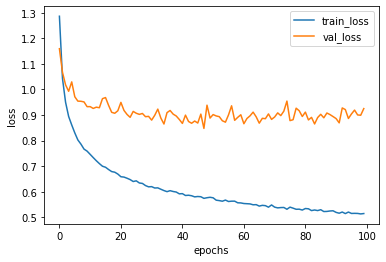

In [19]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

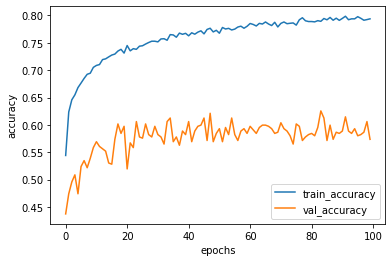

In [20]:
plt.plot(train_acc_list, label='train_accuracy')
plt.plot(val_acc_list, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

<h3> Inference </h3>

In [21]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

In [ ]:
model = timm.create_model('swinv2_large_window12to24_192to384_22kft1k', pretrained=True).to(device)
in_features = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(in_features, 5)
).to(device)

model.load_state_dict(torch.load('twin_v2_off_aug/model.pt'))
model.eval()

In [23]:
valid_path = 'dataset/valid/JPEGImages'
file_list = os.listdir(valid_path)
image_list = []

for file in file_list:
    if '.jpg' in file:
        image_list.append(file)

In [ ]:
def reshape_transform(tensor, height=12, width=12):
    result = tensor.reshape(tensor.size(0),
                            height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = [model.layers[-1].blocks[-1].norm1]

cam = GradCAMPlusPlus(model=model, 
            target_layers=target_layers, 
            reshape_transform=reshape_transform, 
            use_cuda=torch.cuda.is_available())

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
rgb_img = cv2.imread(os.path.join(valid_path, image_list[150]), 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (384, 384))
axs[0].imshow(rgb_img)
axs[0].axis('off')

rgb_img = np.float32(rgb_img) / 255

input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

grayscale_cam = cam(input_tensor=input_tensor,
                    targets=None,)

grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

axs[1].imshow(cam_image)
axs[1].axis('off')
plt.show()